# House Price Prediction Analysis

**목표**: 80개 변수를 활용하여 주택 가격(`SalePrice`)을 예측하는 회귀 모델을 구축합니다.
**데이터셋**: `data/house_train.csv`
**작성자**: AI Assistant
**날짜**: 2026-01-09

## 1. 환경 설정 및 데이터 로드
필요한 라이브러리를 로드하고 데이터를 읽어옵니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew

# 모델링 라이브러리
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import RobustScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgb

# 시각화 설정
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [2]:
# 데이터 로드
df_train = pd.read_csv('../../data/house_train.csv')
print(f"Data Shape: {df_train.shape}")
df_train.head()

Data Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 데이터 프로파일링 (Data Profiling)
데이터의 기본 구조를 확인하고 결측치(Missing Values) 현황을 파악합니다.

결측치가 있는 변수 개수: 19


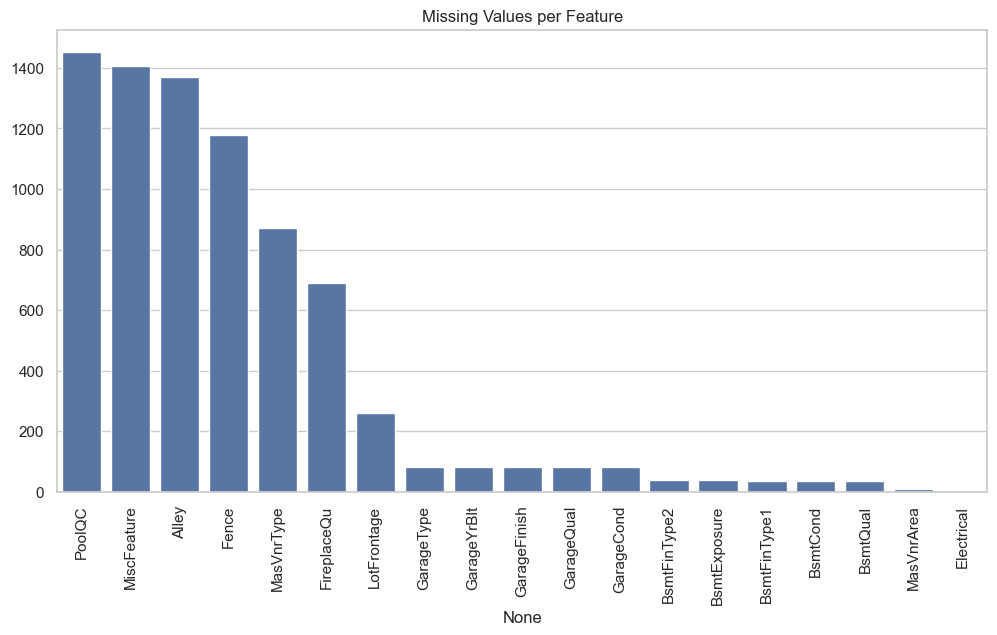

In [3]:
# 데이터 타입 및 결측치 확인
null_counts = df_train.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

print(f"결측치가 있는 변수 개수: {len(null_counts)}")
if len(null_counts) > 0:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=null_counts.index, y=null_counts.values)
    plt.xticks(rotation=90)
    plt.title("Missing Values per Feature")
    plt.show()

**해석**:
- `PoolQC`, `MiscFeature`, `Alley`, `Fence` 등의 변수에서 결측치가 매우 많이 발견됩니다.
- 데이터 명세(Description)에 따르면, 이들의 NA는 '데이터 없음'이 아니라 **'해당 시설이 없음(No Pool, No Alley)'**을 의미합니다.
- 따라서 단순 삭제가 아닌 **'None'이라는 새로운 범주로 대치**하는 작업이 필요합니다.

## 3. 타겟 변수 분석 (Target Analysis)
`SalePrice`의 분포를 확인하고, 정규성 확보를 위해 로그 변환(Log Transformation)을 수행합니다.

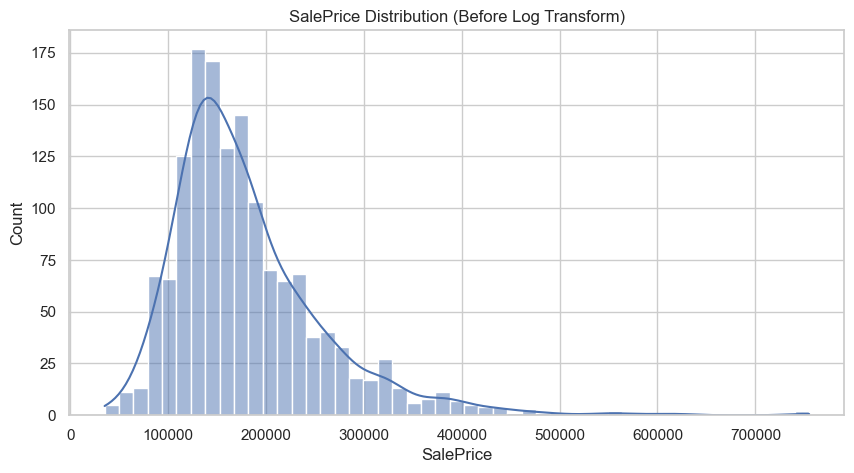

Skewness: 1.88
Kurtosis: 6.54


In [4]:
# SalePrice 분포 확인
plt.figure(figsize=(10, 5))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title("SalePrice Distribution (Before Log Transform)")
plt.show()

print(f"Skewness: {df_train['SalePrice'].skew():.2f}")
print(f"Kurtosis: {df_train['SalePrice'].kurt():.2f}")

**해석**:
- 타겟 변수가 왼쪽으로 치우친(Right-skewed, Skewness > 1) 형태를 보입니다.
- 회귀 모델의 안정성을 높이기 위해 `np.log1p`를 적용하여 정규분포에 가깝게 변환하겠습니다.

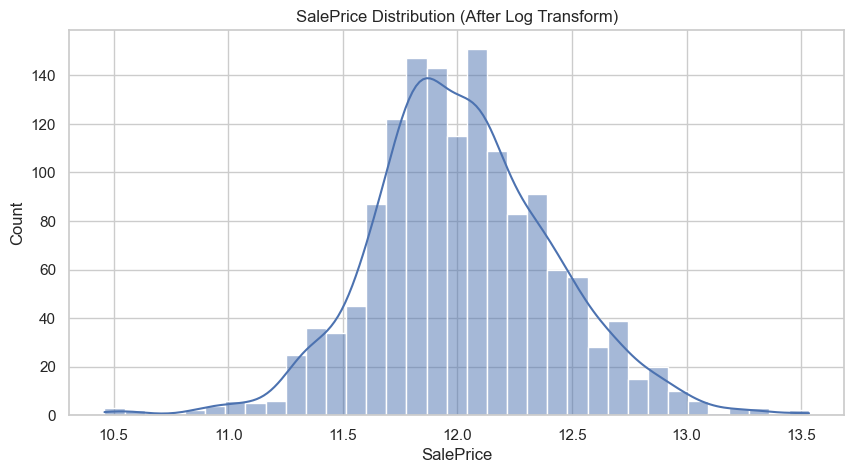

Skewness (After): 0.12


In [5]:
# 로그 변환 적용
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# 변환 후 분포 확인
plt.figure(figsize=(10, 5))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title("SalePrice Distribution (After Log Transform)")
plt.show()

print(f"Skewness (After): {df_train['SalePrice'].skew():.2f}")

## 4. 데이터 전처리 (Preprocessing)
- 결측치(NA)를 의미 있는 값으로 대치합니다.
- 범주형 변수를 수치형으로 변환(Label Encoding/One-Hot Encoding)합니다.

In [6]:
# 1. ID 컬럼 제거 (예측에 불필요)
df_train_id = df_train['Id']
df_train.drop("Id", axis=1, inplace=True)

# 2. Meaningful NA 처리 (시설 없음 의미)
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in none_cols:
    df_train[col] = df_train[col].fillna("None")

# 3. 수치형 변수의 결측치를 0 또는 중앙값으로 대치
# GarageYrBlt, GarageArea, GarageCars -> 0 (차고 없음)
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df_train[col] = df_train[col].fillna(0)

# LotFrontage (도로와 접한 거리) -> 이웃(Neighborhood)의 중앙값으로 대치
df_train['LotFrontage'] = df_train.groupby("Neighborhood")['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# 4. 나머지 결측치 처리 (중요)
# 수치형 변수: 0으로 채움 (MasVnrArea 등)
for col in df_train.select_dtypes(include=[np.number]).columns:
    df_train[col] = df_train[col].fillna(0)

# 범주형 변수: 최빈값(Mode)으로 채움 (MasVnrType, Electrical 등)
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

# 나머지 결측치 확인
remain_null = df_train.isnull().sum().sum()
print(f"처리 후 남은 결측치 수: {remain_null}")

처리 후 남은 결측치 수: 0


## 5. 피처 엔지니어링 (Feature Engineering)
- **Label Encoding**: 순서가 있는 범주형 변수를 숫자로 변환합니다.
- **Dummy Variables**: 순서가 없는 범주형 변수를 One-Hot Encoding 합니다.

In [7]:
# 순서가 있는 범주형 변수 처리 (Label Encoding)
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    df_train[c] = lbl.fit_transform(list(df_train[c].values))

# 전체 범주형 변수 One-Hot Encoding
df_train = pd.get_dummies(df_train)
print(f"최종 데이터 Shape: {df_train.shape}")

최종 데이터 Shape: (1460, 222)


## 6. 모델링 (Modeling)
- **Train/Validation Split**: 모델 검증을 위해 데이터를 분리합니다.
- **Baseline**: Linear Regression

In [8]:
y = df_train['SalePrice']
X = df_train.drop(['SalePrice'], axis=1)

# 학습/검증 데이터 분리 (8:2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 평가 함수 (RMSLE: Root Mean Squared Log Error)
# 이미 Target이 Log 변환되었으므로 RMSE를 계산하면 RMSLE와 동일합니다.
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Baseline: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

print(f"Linear Regression RMSLE: {rmsle(y_val, lr_pred):.4f}")

Linear Regression RMSLE: 0.1276


## 7. 심화 모델링 (Advanced Modeling)
- **XGBoost**: Gradient Boosting 계열의 강력한 모델.
- **LightGBM**: 빠르고 가벼우면서도 높은 성능을 보여주는 모델.

In [9]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

print(f"XGBoost RMSLE: {rmsle(y_val, xgb_pred):.4f}")

XGBoost RMSLE: 0.1385


In [10]:
# LightGBM
# LightGBM은 컬럼명에 특수문자가 있으면 오류가 발생할 수 있어 처리가 필요할 수 있습니다.
import re
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=1000, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)

print(f"LightGBM RMSLE: {rmsle(y_val, lgb_pred):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3158
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 137
[LightGBM] [Info] Start training from score 12.030658


LightGBM RMSLE: 0.1365


## 8. 모델 해석 및 저장
- Feature Importance를 통해 가격 결정에 중요한 변수를 확인합니다.

<Figure size 1000x800 with 0 Axes>

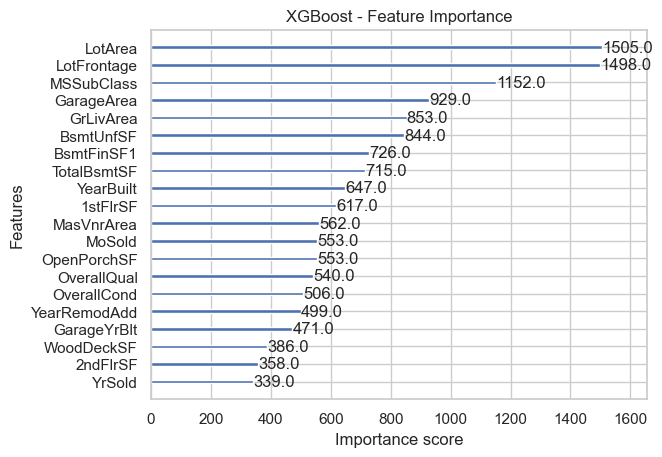

In [11]:
# XGBoost Feature Importance 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title("XGBoost - Feature Importance")
plt.show()

In [12]:
# 최적 모델 저장 (XGBoost)
import joblib
import os

if not os.path.exists('./model'):
    os.makedirs('./model')

joblib.dump(xgb_model, './model/best_house_model.pkl')
print("Model saved to ./model/best_house_model.pkl")

Model saved to ./model/best_house_model.pkl
